In [20]:
# Import required packages
from langchain_milvus import Milvus
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from sentence_transformers import SentenceTransformer
import requests
import urllib3
import os

# IMPORTANT: Clear any old SSL environment variables from previous runs
for env_var in ['REQUESTS_CA_BUNDLE', 'SSL_CERT_FILE', 'CURL_CA_BUNDLE']:
    if env_var in os.environ:
        del os.environ[env_var]
        print(f"🧹 Cleared old {env_var}")

# Configuration
MILVUS_HOST = "127.0.0.1"
MILVUS_PORT = "19530"
COLLECTION_NAME = "sec_filings"
EMBED_MODEL = "all-MiniLM-L6-v2"  # Same as SECRag.ipynb

print("✅ Imports complete")
print(f"📊 Config: {MILVUS_HOST}:{MILVUS_PORT}, collection: {COLLECTION_NAME}")


✅ Imports complete
📊 Config: 127.0.0.1:19530, collection: sec_filings


In [21]:
# Load SentenceTransformer model (same as SECRag.ipynb)
print(f"📥 Loading model: {EMBED_MODEL}...")

embedder = SentenceTransformer(EMBED_MODEL)
DIM = embedder.get_sentence_embedding_dimension()

print(f"✅ Model loaded: {EMBED_MODEL}")
print(f"   Dimension: {DIM}")


📥 Loading model: all-MiniLM-L6-v2...
✅ Model loaded: all-MiniLM-L6-v2
   Dimension: 384


In [22]:
# Create custom embedding function (same as SECRag approach)
class SentenceTransformerEmbeddings:
    """Custom embedding function using SentenceTransformer directly"""
    
    def __init__(self, model):
        self.model = model
    
    def embed_documents(self, texts):
        """Embed a list of documents"""
        return self.model.encode(texts, normalize_embeddings=True).tolist()
    
    def embed_query(self, text):
        """Embed a single query"""
        return self.model.encode([text], normalize_embeddings=True)[0].tolist()

# Create embeddings object
embeddings = SentenceTransformerEmbeddings(embedder)

print(f"✅ Custom embedding function created")
print(f"   Uses: SentenceTransformer (same as SECRag.ipynb)")
print(f"   Normalization: True")


✅ Custom embedding function created
   Uses: SentenceTransformer (same as SECRag.ipynb)
   Normalization: True


In [23]:
# Connect to Milvus
vector_store = Milvus(
    embedding_function=embeddings,
    collection_name=COLLECTION_NAME,
    connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT},
    text_field="text",
    vector_field="embedding",
    auto_id=True
)

print(f"✅ Connected to Milvus: {COLLECTION_NAME}")
print(f"   Host: {MILVUS_HOST}:{MILVUS_PORT}")


✅ Connected to Milvus: sec_filings
   Host: 127.0.0.1:19530


In [24]:
# Test retrieval
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
docs = retriever.invoke("What was Amazon's revenue in Q1 2023?")

print(f"✅ Retrieved {len(docs)} documents\\n")
for i, doc in enumerate(docs[:3], 1):
    print(f"{i}. {doc.metadata.get('filename')} (Page {doc.metadata.get('page')})")
    print(f"   {doc.metadata.get('company')} {doc.metadata.get('quarter')} {doc.metadata.get('year')}")
    print(f"   Preview: {doc.page_content[:150]}...\\n")


✅ Retrieved 5 documents\n
1. 2022 Q3 AMZN.pdf (Page 27)
   AMZN Q3 2022
   Preview: Table of Contents
While costs associated with Amazon Prime membership benefits and other shipping offers are not included in sales and marketing expen...\n
2. 2023 Q2 AMZN.pdf (Page 3)
   AMZN Q2 2023
   Preview: Table of Contents
AMAZON.COM, INC.
CONSOLIDATED STATEMENTS OF OPERATIONS
(in millions, except per share data)
(unaudited)
  Three Months EndedJune 30,...\n
3. 2023 Q3 AMZN.pdf (Page 3)
   AMZN Q3 2023
   Preview: Table of Contents
AMAZON.COM, INC.
CONSOLIDATED STATEMENTS OF OPERATIONS
(in millions, except per share data)
(unaudited)
  Three Months EndedSeptembe...\n


In [25]:
# NetApp LLM Configuration
NETAPP_LLM_ENDPOINT = "https://llm-proxy-api.ai.eng.netapp.com/v1/completions"
NETAPP_API_KEY = "sk_54508d6938935f6e4472170ee0d5beb05e725e91d3da9f0effb48c60e902960d"
NETAPP_USER = "pg47711"
NETAPP_MODEL = "gpt-5"

# SSL Fix for self-signed certificates
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

print("✅ NetApp LLM configured")
print(f"   Endpoint: {NETAPP_LLM_ENDPOINT}")
print(f"   Model: {NETAPP_MODEL}, User: {NETAPP_USER}")


✅ NetApp LLM configured
   Endpoint: https://llm-proxy-api.ai.eng.netapp.com/v1/completions
   Model: gpt-5, User: pg47711


In [26]:
# Test NetApp LLM
response = requests.post(
    NETAPP_LLM_ENDPOINT,
    headers={"Content-Type": "application/json", "Authorization": f"Bearer {NETAPP_API_KEY}"},
    json={"model": NETAPP_MODEL, "user": NETAPP_USER, "prompt": "What is 2+2?"},
    verify=False,
    timeout=10
)

if response.status_code == 200:
    answer = response.json()["choices"][0]["text"]
    print(f"✅ LLM Working! Answer: '{answer}'")
    print(f"   Answer location: response['choices'][0]['text']")
else:
    print(f"❌ Error {response.status_code}: {response.text[:100]}")


✅ LLM Working! Answer: '4'
   Answer location: response['choices'][0]['text']


In [27]:
# Define RAG State
class RAGState(TypedDict):
    question: str
    context: List[Document]
    answer: str
    metadata_filter: str
    retrieved_count: int

print("✅ RAG State defined with 5 fields")


✅ RAG State defined with 5 fields


In [28]:
# Retrieval Node
def retrieve_documents(state: RAGState) -> RAGState:
    question = state["question"]
    metadata_filter = state.get("metadata_filter", "")
    
    print(f"\\n🔍 Retrieving for: '{question}'")
    if metadata_filter:
        print(f"   Filter: {metadata_filter}")
    
    # Create retriever with optional filter
    search_kwargs = {"k": 5}
    if metadata_filter:
        search_kwargs["expr"] = metadata_filter
    
    temp_retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs=search_kwargs
    )
    
    docs = temp_retriever.invoke(question)
    print(f"   ✅ Retrieved {len(docs)} documents")
    
    for i, doc in enumerate(docs[:3], 1):
        print(f"   {i}. {doc.metadata.get('filename')} (Page {doc.metadata.get('page')})")
    
    return {
        "question": question,
        "context": docs,
        "metadata_filter": metadata_filter,
        "retrieved_count": len(docs),
        "answer": ""
    }

print("✅ Retrieval node defined")


✅ Retrieval node defined


In [29]:
# Generation Node
def generate_answer(state: RAGState) -> RAGState:
    question = state["question"]
    context_docs = state["context"]
    
    print(f"\\n💡 Generating answer...")
    
    # Format context
    context_text = "\\n\\n".join([
        f"[{doc.metadata.get('filename')}, Page {doc.metadata.get('page')}]\\n{doc.page_content[:500]}"
        for doc in context_docs[:3]
    ])
    
    # Create prompt
    prompt = f"""You are an assistant for question-answering tasks. Use the retrieved context to answer the question. If you don't know, say so. Max 3 sentences, keep it concise.

Question: {question}

Context:
{context_text}

Answer:"""
    
    try:
        # Call NetApp LLM
        response = requests.post(
            NETAPP_LLM_ENDPOINT,
            headers={"Content-Type": "application/json", "Authorization": f"Bearer {NETAPP_API_KEY}"},
            json={"model": NETAPP_MODEL, "user": NETAPP_USER, "prompt": prompt},
            timeout=60,
            verify=False
        )
        
        if response.status_code == 200:
            answer = response.json()["choices"][0]["text"].strip()
            print(f"   ✅ Answer received ({len(answer)} chars)")
        else:
            answer = f"API Error ({response.status_code}): {response.text[:100]}"
            print(f"   ❌ {answer}")
            
    except Exception as e:
        answer = f"Error: {str(e)[:100]}\\n\\nContext: {context_text[:300]}..."
        print(f"   ❌ {str(e)[:50]}")
    
    return {**state, "answer": answer}

print("✅ Generation node defined")


✅ Generation node defined


In [30]:
# Build workflow
workflow = StateGraph(RAGState)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)
app = workflow.compile()

print("✅ Workflow compiled: START → retrieve → generate → END")


✅ Workflow compiled: START → retrieve → generate → END


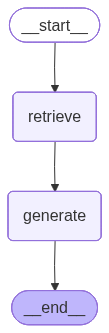

✅ Diagram displayed above


In [31]:
# Visualize workflow
try:
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Diagram displayed above")
except:
    print("START → retrieve → generate → END")


In [32]:
# Test 1
print("="*80)
print("🧪 TEST 1: Basic Query")
print("="*80)

result = app.invoke({
    "question": "What were NVIDIA's Q3 2023 revenue highlights?",
    "context": [],
    "answer": "",
    "metadata_filter": "",
    "retrieved_count": 0
})

print(f"\\n{'='*80}\\n📝 ANSWER:\\n{'='*80}")
print(result["answer"])
print("="*80)


🧪 TEST 1: Basic Query
\n🔍 Retrieving for: 'What were NVIDIA's Q3 2023 revenue highlights?'
   ✅ Retrieved 5 documents
   1. 2023 Q2 NVDA.pdf (Page 22)
   2. 2023 Q3 NVDA.pdf (Page 22)
   3. 2023 Q3 NVDA.pdf (Page 23)
\n💡 Generating answer...


   ✅ Answer received (257 chars)
\n================================================================================\n📝 ANSWER:\n================================================================================
For Q3 2023 (three months ended Oct 29, 2023), NVIDIA reported $18.12B in revenue, up from $5.93B a year earlier. Segment mix: $14.65B from Compute & Networking and $3.48B from Graphics; by geography: U.S. $6.30B, Taiwan $4.33B, and China (incl. HK) $4.03B.


In [33]:
# Test 2
print("="*80)
print("🧪 TEST 2: Filtered Query (AMZN Q1 2023)")
print("="*80)

result = app.invoke({
    "question": "What were the key financial metrics?",
    "context": [],
    "answer": "",
    "metadata_filter": 'company == "AMZN" and year == 2023 and quarter == "Q1"',
    "retrieved_count": 0
})

print(f"\\n{'='*80}\\n📝 ANSWER:\\n{'='*80}")
print(result["answer"])
print("="*80)


🧪 TEST 2: Filtered Query (AMZN Q1 2023)
\n🔍 Retrieving for: 'What were the key financial metrics?'
   Filter: company == "AMZN" and year == 2023 and quarter == "Q1"
   ✅ Retrieved 5 documents
   1. 2023 Q1 AMZN.pdf (Page 10)
   2. 2023 Q1 AMZN.pdf (Page 28)
   3. 2023 Q1 AMZN.pdf (Page 9)
\n💡 Generating answer...
   ✅ Answer received (456 chars)
\n================================================================================\n📝 ANSWER:\n================================================================================
- Other operating expense (income), net: $249 million in Q1 2022 vs $223 million in Q1 2023; interest income: $108 million in Q1 2022 vs $611 million in Q1 2023.
- Cash and marketable securities at fair value included cash of $10,968 million as of March 31, 2023 (vs $10,666 million at December 31, 2022), held primarily in AAA-rated money market funds, government and agency securities, other investment-grade securities, and marketable equity securities.


In [34]:
# Helper function
def ask_question(question: str, filter_expr: str = ""):
    print(f"\\n❓ {question}")
    if filter_expr:
        print(f"🔍 {filter_expr}")
    
    result = app.invoke({
        "question": question,
        "context": [],
        "answer": "",
        "metadata_filter": filter_expr,
        "retrieved_count": 0
    })
    
    print(f"\\n📝 ANSWER:\\n{result['answer']}\\n{'='*80}")
    return result["answer"]

print("✅ Helper function ready")
print("Usage: ask_question('What was revenue?', 'company == \"NVDA\"')")


✅ Helper function ready
Usage: ask_question('What was revenue?', 'company == "NVDA"')


In [35]:
# ========== CUSTOMIZE HERE ==========
my_question = "What was Microsoft's cloud revenue growth?"
my_filter = 'company == "MSFT" and year == 2023'
# ====================================

answer = ask_question(my_question, my_filter)


\n❓ What was Microsoft's cloud revenue growth?
🔍 company == "MSFT" and year == 2023
\n🔍 Retrieving for: 'What was Microsoft's cloud revenue growth?'
   Filter: company == "MSFT" and year == 2023
   ✅ Retrieved 5 documents
   1. 2023 Q3 MSFT.pdf (Page 34)
   2. 2023 Q2 MSFT.pdf (Page 36)
   3. 2023 Q1 MSFT.pdf (Page 38)
\n💡 Generating answer...
   ✅ Answer received (71 chars)
\n📝 ANSWER:\nThe provided context does not specify Microsoft’s cloud revenue growth.\n================================================================================
